# Metagenomics Basic Analyses

## Metagenomics Data Analysis: Diversity and Ordination

This is a comprehensive notebook for performing a preliminary analysis of gut metagenomic data from the Human Microbiome Project 2 (HMP2) to explore microbial community structure, focusing on **alpha diversity** and **beta diversity** in relation to Inflammatory Bowel Disease (IBD) diagnosis (Crohn's Disease (**CD**), Ulcerative Colitis (**UC**), and **nonIBD** controls).

We will use the Python library **`scikit-bio`**, a bioinformatics package that provides functions for diversity analysis (alpha and beta) and ordination methods like Principal Coordinate Analysis (PCoA).

In [ ]:
!pip install scikit-bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 45.2 MB/s eta 0:00:00


## Data Setup: Directory Creation and Downloads

These cells set up the working environment by creating necessary directories and downloading the raw data files from the HMP2 public repository.

1.  **Directory Creation:** Creates `metagenomics/data` and `metagenomics/results` folders to organize input and output files.
2.  **Data Download:**
      * Downloads a gzipped file containing the **taxonomic profiles** (`taxonomic_profiles.tsv.gz`), which is an abundance table where rows are microbial taxa and columns are samples. This file is then unzipped.
      * Downloads the **sample metadata** (`hmp2_metadata_2018-08-20.csv`), which contains information about each sample, including the participant's diagnosis.

In [2]:
! mkdir metagenomics
! mkdir metagenomics/data
! mkdir metagenomics/results

In [3]:
! wget https://g-227ca.190ebd.75bc.data.globus.org/ibdmdb/products/HMP2/MGX/2018-05-04/taxonomic_profiles.tsv.gz -O metagenomics/data/taxonomic_profiles.tsv.gz
! gunzip metagenomics/data/taxonomic_profiles.tsv.gz

--2025-11-09 11:52:09--  https://g-227ca.190ebd.75bc.data.globus.org/ibdmdb/products/HMP2/MGX/2018-05-04/taxonomic_profiles.tsv.gz
Resolving g-227ca.190ebd.75bc.data.globus.org (g-227ca.190ebd.75bc.data.globus.org)... 140.247.111.40, 140.247.111.39
Connecting to g-227ca.190ebd.75bc.data.globus.org (g-227ca.190ebd.75bc.data.globus.org)|140.247.111.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘metagenomics/data/taxonomic_profiles.tsv.gz’

metagenomics/data/t     [ <=>                ] 651.01K  4.10MB/s    in 0.2s    

2025-11-09 11:52:10 (4.10 MB/s) - ‘metagenomics/data/taxonomic_profiles.tsv.gz’ saved [666634]



In [4]:
! wget https://g-227ca.190ebd.75bc.data.globus.org/ibdmdb/metadata/hmp2_metadata_2018-08-20.csv -O metagenomics/data/hmp2_metadata_2018-08-20.csv

--2025-11-09 11:52:10--  https://g-227ca.190ebd.75bc.data.globus.org/ibdmdb/metadata/hmp2_metadata_2018-08-20.csv
Resolving g-227ca.190ebd.75bc.data.globus.org (g-227ca.190ebd.75bc.data.globus.org)... 140.247.111.40, 140.247.111.39
Connecting to g-227ca.190ebd.75bc.data.globus.org (g-227ca.190ebd.75bc.data.globus.org)|140.247.111.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘metagenomics/data/hmp2_metadata_2018-08-20.csv’

metagenomics/data/h     [  <=>               ]   8.65M  23.8MB/s    in 0.4s    

2025-11-09 11:52:11 (23.8 MB/s) - ‘metagenomics/data/hmp2_metadata_2018-08-20.csv’ saved [9074342]



## Data Loading, Inspection, and Filtering

The raw data is loaded into `pandas` DataFrames, the sample IDs are set as the index, and an initial filtering step is performed to prepare the data for analysis.

**Loading Data:** The taxonomic profile table (`data`) and the metadata table (`metadata`) are loaded and indexed by their respective IDs.

In [5]:
import pandas as pd

data = pd.read_csv('metagenomics/data/taxonomic_profiles.tsv', sep='\t')
data = data.set_index('#SampleID')
print(data.head())

metadata = pd.read_csv('metagenomics/data/hmp2_metadata_2018-08-20.csv')
metadata = metadata.set_index('External ID')
print(metadata.head())

                                                    CSM5FZ4M  CSM5MCUO  \
#SampleID                                                                
k__Archaea                                               0.0       0.0   
k__Archaea|p__Euryarchaeota                              0.0       0.0   
k__Archaea|p__Euryarchaeota|c__Methanobacteria           0.0       0.0   
k__Archaea|p__Euryarchaeota|c__Methanobacteria|...       0.0       0.0   
k__Archaea|p__Euryarchaeota|c__Methanobacteria|...       0.0       0.0   

                                                    CSM5MCVL  CSM5MCVN  \
#SampleID                                                                
k__Archaea                                               0.0       0.0   
k__Archaea|p__Euryarchaeota                              0.0       0.0   
k__Archaea|p__Euryarchaeota|c__Methanobacteria           0.0       0.0   
k__Archaea|p__Euryarchaeota|c__Methanobacteria|...       0.0       0.0   
k__Archaea|p__Euryarchaeota|c__Methan

/tmp/ipython-input-4272185344.py:7: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('metagenomics/data/hmp2_metadata_2018-08-20.csv')


**Note:** There is a lot of metadata available for these samples.

In [6]:
metadata.columns.tolist()

['Project',
 'Participant ID',
 'site_sub_coll',
 'data_type',
 'week_num',
 'date_of_receipt',
 'interval_days',
 'visit_num',
 'Research Project',
 'PDO Number',
 'GSSR IDs',
 'Product',
 'LCSET',
 'Aggregated Lanes',
 'WR ID',
 '# Lanes in Aggregation',
 'reads_raw',
 'reads_filtered',
 'reads_qc_fail',
 'reads_human',
 'reads_ribosomal',
 'reads_viral',
 'Delta',
 'IntervalName',
 'IntervalSequence',
 'ProjectSpecificID',
 'site_name',
 'Age at diagnosis',
 'Has the subject had a cholecystectomy?',
 'Has the subject had a prior abdominal surgery (other)?',
 'Has the next visit been scheduled?',
 'Has the subject been given new stool kits?',
 'Has the subject completed the FFQ/YAQ?',
 'Education Level',
 'Occupation',
 'Scanned FFQ/YAQ document:',
 'FFQ/YAQ results:',
 'Has the subject had an appendectomy?',
 'Has the subject had a tonsillectomy?',
 'biopsy_location',
 'Were study bloods drawn?',
 'Whole blood received at Broad:',
 'Serum tube #1 received at CSMC:',
 'Serum tubes #2

**Important:** We will focus only on the diagnosis groups.

In [7]:
groups = metadata[['diagnosis']].reset_index().drop_duplicates().set_index('External ID')

## Alpha Diversity Analysis (Shannon Index)

**Alpha diversity** is a metric used to assess the diversity within a single community (a single sample in this case). The **Shannon diversity index** quantifies the uncertainty in predicting the species identity of an individual randomly selected from a sample. Higher values indicate higher diversity and richness.

### Method: Shannon Index

The code uses the `scikit-bio` library to:

1.  **Calculate Shannon Diversity:** Apply the **'shannon' metric** from the `alpha_diversity` function to the sample-by-taxa abundance table.
2.  **Merge Data:** Join the calculated diversity scores with the sample diagnosis metadata, preparing the results for statistical comparison and plotting.

In [8]:
from skbio.diversity.alpha import shannon
from skbio.stats.ordination import pcoa

alpha_diversity = {}

for col in data.columns:
    alpha_diversity[col] = shannon(data[col], base=2)

alpha_diversity = pd.DataFrame.from_dict(alpha_diversity, orient='index')

In [ ]:
alpha_diversity.head()

,0
CSM5FZ4M,4.411125
CSM5MCUO,5.122843
CSM5MCVL,4.565702
CSM5MCVN,4.459389
CSM5MCW6,3.883694
...,...
CSM6J2H9_P,4.919003
HSM5MD4A_P,4.804397
CSM5MCUW_P,4.995571
ESM5MEBA_P,4.522293


In [10]:
groups.head()

,diagnosis
External ID,
206615,CD
206614,CD
206617,CD
206619,CD
206616,CD


In [11]:
alpha_diversity_df = pd.DataFrame({
    'Shannon_Diversity': alpha_diversity.iloc[:, 0],
    'Group': [groups.loc[i, 'diagnosis'] for i in alpha_diversity.index]
})
alpha_diversity_df.head()

,Shannon_Diversity,Group
CSM5FZ4M,4.411125,UC
CSM5MCUO,5.122843,UC
CSM5MCVL,4.565702,CD
CSM5MCVN,4.459389,CD
CSM5MCW6,3.883694,CD


## Visualization: Alpha Diversity Comparison

To visually compare the microbial diversity between the different disease groups (**nonIBD**, **CD** (Crohn's Disease), and **UC** (Ulcerative Colitis)), a **boxplot** is generated.

Boxplots are ideal for summarizing the distribution of a continuous variable (**Shannon Diversity**) across multiple categorical groups (**Diagnosis**). This plot will show the median, quartiles, and range of the alpha diversity for each diagnostic group, allowing for a visual assessment of whether IBD is associated with reduced or altered microbial diversity.


## Alpha Diversity (Shannon) Test
Mann-Whitney U P-value: 0.0349


/tmp/ipython-input-3723597431.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Shannon_Diversity', data=alpha_diversity_df, palette='Set2')


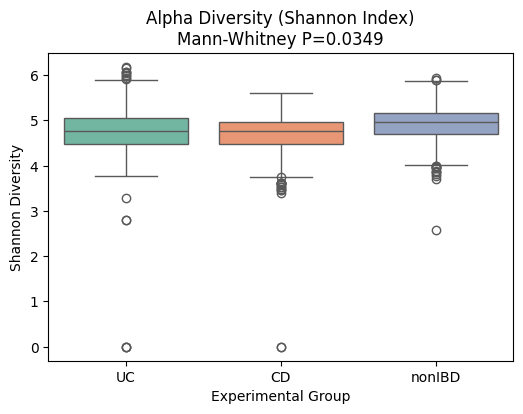

In [ ]:
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical test for Alpha Diversity between groups
stat, p_alpha = mannwhitneyu(
    alpha_diversity_df[alpha_diversity_df['Group'] == 'CD']['Shannon_Diversity'],
    alpha_diversity_df[alpha_diversity_df['Group'] == 'UC']['Shannon_Diversity']
)

print(f"\n## Alpha Diversity (Shannon) Test")
print(f"Mann-Whitney U P-value: {p_alpha:.4f}")

# Visualization of Alpha Diversity
plt.figure(figsize=(6, 4))
sns.boxplot(x='Group', y='Shannon_Diversity', data=alpha_diversity_df, palette='Set2')
plt.title(f'Alpha Diversity (Shannon Index)\nMann-Whitney P={p_alpha:.4f}')
plt.xlabel('Experimental Group')
plt.ylabel('Shannon Diversity')
plt.savefig('metagenomics/results/alpha_diversity_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

## Differential Abundance Testing (Taxonomic)

**Differential abundance testing** goes beyond diversity metrics to identify **specific microbial taxa** that are statistically different in relative abundance between two or more groups (e.g., a specific *species* that is higher in CD patients compared to UC patients).

### Method: Mann-Whitney U Test and FDR Correction

This section uses the **Mann-Whitney U test** (a non-parametric test) to compare the distribution of relative abundances for each taxon between the two defined groups (Crohn's Disease vs. non-IBD control). The Mann-Whitney U test is ideal for this type of data as microbial abundances are often non-normally distributed and contain many zeros.

The code performs the following steps:

1.  **Define Groups:** Selects sample indices for the two comparison groups ('CD' vs. 'nonIBD').
2.  **Iterate and Test:** Iterates through every microbial taxon and calculates the **Mann-Whitney U test** (via `scipy.stats.ranksums` or `scipy.stats.mannwhitneyu`) to get a raw p-value for the difference in abundance.
3.  **Multiple Testing Correction (FDR):** The resulting raw p-values are then adjusted using the **Benjamini-Hochberg False Discovery Rate (FDR)** method (`smm.multipletests`). This is a crucial step to control the number of false positives that occur when performing thousands of individual tests.
4.  **Reporting:** Taxa with an adjusted p-value (FDR\_P\_Value) below the significance threshold (e.g., $0.05$) are reported as **significantly differentially abundant**.


In [ ]:


# We'll test for taxa significantly different between CD and UC
p_values = {}
for taxa_name in data.index:
    group_a_data = data.loc[taxa_name, list(set(data.columns).intersection(groups[groups['diagnosis'] == 'CD'].index))]
    group_b_data = data.loc[taxa_name, list(set(data.columns).intersection(groups[groups['diagnosis'] == 'UC'].index))]

    # Use Mann-Whitney U test (non-parametric, suitable for non-normal count data)
    stat, p_val = mannwhitneyu(group_a_data, group_b_data, alternative='two-sided')
    p_values[taxa_name] = p_val

# Convert results to DataFrame and apply multiple testing correction (e.g., Benjamini/Hochberg FDR)
diff_taxa_results = pd.DataFrame(list(p_values.items()), columns=['Taxa', 'P_Value'])
from statsmodels.sandbox.stats.multicomp import multipletests
_, corrected_p, _, _ = multipletests(diff_taxa_results['P_Value'], method='fdr_bh')
diff_taxa_results['FDR_P_Value'] = corrected_p

significant_taxa = diff_taxa_results[diff_taxa_results['FDR_P_Value'] < 0.05].sort_values('FDR_P_Value')

print(f"\n## Differential Abundance Test (Mann-Whitney U, FDR_P_Value < 0.05)")
print(f"Found {len(significant_taxa)} significantly different taxa:")
print(significant_taxa.head())
significant_taxa.to_csv('metagenomics/results/significant_taxa.csv', index=False)
print("-" * 40)




## Differential Abundance Test (Mann-Whitney U, P < 0.05)
Found 410 significantly different taxa:
                                                  Taxa       P_Value
766  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...  5.994635e-18
767  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...  5.994635e-18
765  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...  2.358778e-16
266  k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...  8.721310e-14
270  k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...  1.455894e-13
----------------------------------------


## Principal Component Analysis (PCA)

Although **PCoA** (using distances like Bray-Curtis) is standard, **Principal Component Analysis (PCA)** is a robust way to visualize clustering. Use the relative abundance data (Taxa as features, Samples as observations).

### Method: Principal Component Analysis (PCA)

**PCA** is an **ordination method** primarily used for **dimensionality reduction** on the *raw* or *normalized* **abundance data** itself, not on a distance matrix.

  * **Goal:** To find a set of orthogonal axes (Principal Components, or PCs) that capture the maximum possible **variance** in the *taxa abundances* across all samples.
  * **Interpretation:** PCA identifies co-varying groups of taxa that are responsible for the differences between samples. An ordination plot would show samples clustered by overall abundance profile, and a **biplot** could show which specific taxa (vectors) drive the separation.

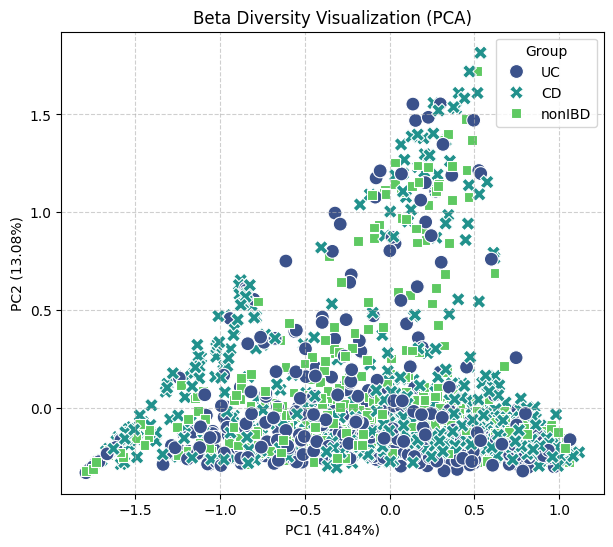

In [ ]:

from sklearn.decomposition import PCA
X = data.T # Transpose: Samples are rows, Taxa are columns

# Run PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=X.index)
pca_df['Group'] = [groups.loc[i, 'diagnosis'] for i in pca_df.index]

explained_variance = pca.explained_variance_ratio_

# Visualization of Beta Diversity
plt.figure(figsize=(7, 6))
sns.scatterplot(
    x='PC1', y='PC2', hue='Group', data=pca_df,
    s=100, palette='viridis', style='Group'
)
plt.title('Beta Diversity Visualization (PCA)')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Group')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('metagenomics/results/beta_diversity_pca.png', dpi=300, bbox_inches='tight')
plt.show()

## Beta Diversity Analysis: Bray-Curtis and PCoA

**Beta diversity** measures the difference in microbial community composition ***between*** samples. It is used to determine if the microbial community structure differs significantly across groups (e.g., between CD and nonIBD subjects).

### Method: Bray-Curtis Dissimilarity (Beta Diversity Metric)

The **Bray-Curtis dissimilarity** is an abundance-based **beta diversity metric** that quantifies the difference in microbial composition between two samples. A distance matrix is calculated, where each cell contains the Bray-Curtis distance (0 = identical, 1 = maximally different) between a pair of samples.

### Method: Principal Coordinate Analysis (PCoA)

**Principal Coordinate Analysis (PCoA)** (also known as Multidimensional Scaling, MDS) is an **ordination method** used to visualize the distances in the Bray-Curtis matrix in a low-dimensional space (typically 2D or 3D).

  * It finds a set of orthogonal axes (Principal Coordinates) that best represent the variation between samples based on the distance matrix.
  * The output reports the percentage of total variation explained by the first two axes (**PC1** and **PC2**), indicating how much of the original data's variability is captured in the 2D plot.


In [ ]:
import numpy as np
from skbio.stats.ordination import pcoa
from skbio.diversity import beta_diversity

# Set a style for better plot aesthetics
sns.set_style("whitegrid")

# Calculate Beta-Diversity (Distance Matrix)
# PCoA requires a distance matrix, which is computed using a beta-diversity metric.
# Common metrics are Bray-Curtis, Jaccard, or UniFrac (if you have a phylogenetic tree).
print("--- Calculating Bray-Curtis Distance ---")

# Calculate Bray-Curtis distance
# 'braycurtis' is the metric, samples_taxa_df is the data, sample_ids are the indices
bray_curtis_dm = beta_diversity(
    metric='braycurtis',
    counts=data.T.values,
    ids=data.T.index
)

# bray_curtis_dm is a skbio.stats.distance.DistanceMatrix object
print(f"Distance Matrix Shape: {bray_curtis_dm.shape}\n")


# Perform PCoA
print("--- Performing PCoA ---")

# Run Principal Coordinate Analysis
# The input is the DistanceMatrix object
pcoa_results = pcoa(bray_curtis_dm)

# Access the proportion of variance explained by each axis
explained_variance = pcoa_results.proportion_explained
pc1_var = explained_variance.iloc[0] * 100
pc2_var = explained_variance.iloc[1] * 100

print(f"PC1 explains: {pc1_var:.2f}%")
print(f"PC2 explains: {pc2_var:.2f}%\n")

# Access the coordinates for plotting
pcoa_coords = pcoa_results.samples
pcoa_coords = pcoa_coords.iloc[:, [0, 1]].rename(columns={
    pcoa_coords.columns[0]: 'PC1',
    pcoa_coords.columns[1]: 'PC2'
})



--- Calculating Bray-Curtis Distance ---
Distance Matrix Shape: (1638, 1638)

--- Performing PCoA ---


/usr/local/lib/python3.12/dist-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(


PC1 explains: 25.56%
PC2 explains: 9.17%



/usr/local/lib/python3.12/dist-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:275: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -1.5137206528652376 whereas the largest positive one is 63.563217229864264.
  warn(


## Visualization: PCoA Ordination Plot

The final step is to plot the sample coordinates from the PCoA (PC1 vs. PC2) to visualize how the overall microbial communities cluster.

### Interpretation

By coloring the points on the scatter plot according to the sample's **Diagnosis** (CD, UC, nonIBD), we can visually assess the **beta diversity**. If samples from the same diagnostic group cluster together and are separate from other groups, it suggests that the disease is a major factor shaping

--- Plotting PCoA Results ---


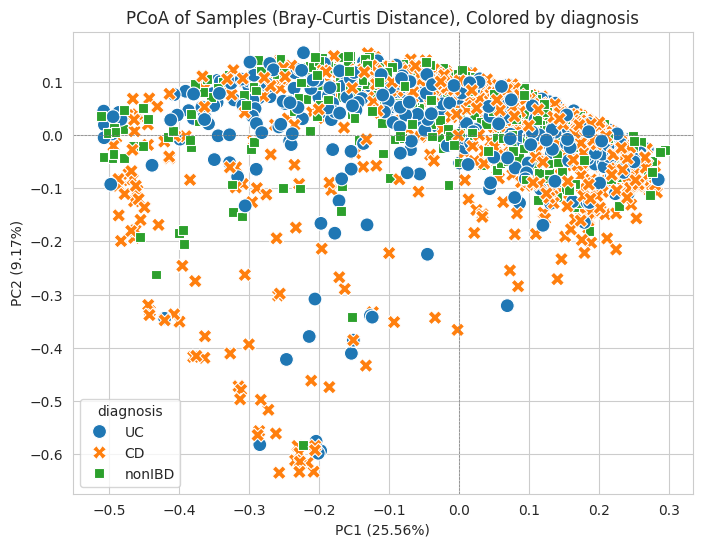

In [ ]:
# Merge the PCoA coordinates with the sample metadata
plot_data = pcoa_coords.join(groups)
plot_column = 'diagnosis' # The metadata column to color the plot by

# Plotting with Matplotlib/Seaborn
print("--- Plotting PCoA Results ---")

plt.figure(figsize=(8, 6))

# Use seaborn for easy coloring by the categorical metadata column - Diagnosis
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue=plot_column,
    data=plot_data,
    s=100, # size of points
    style=plot_column # adds a different shape for each group
)

# Set the axis labels with the explained variance
plt.xlabel(f'PC1 ({pc1_var:.2f}%)')
plt.ylabel(f'PC2 ({pc2_var:.2f}%)')
plt.title(f'PCoA of Samples (Bray-Curtis Distance), Colored by {plot_column}')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.legend(title=plot_column, loc='best')
plt.savefig('metagenomics/results/beta_diversity_PCoA.png', dpi=300, bbox_inches='tight')
plt.show()